In this notebook, we show the simulation for the Group One design.

Group one shows quantiles and means can reflect different preference order and the quantiles are preferred by the risk-averse agents, i.e. Arm B is preferred since its less low rewards.
We compare our algorithms with the quantile-based baseline algorithms in terms of Group One design.

To be able to compare with quantile based baseline algorithm, our first group of experiment is constraint with identifying a single arm ($m$ = 1). We consider $K = 20$ arms with 15 arm A, 1 arm B and 4 arm C. The quality of arm is evaluated by 0.5-quantile ($\tau = 0.5$). The optimal arm  is $B$.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.BAI_FixedBudget import *
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import plot_hist, plot_eva, plot_eva_m

%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# environment

environments = [
    {Mixture_AbsGau: [[4.5, 2, 0, 1, 1], 
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1], 
                      [0, 2, 0,1, 1],  
                      [0, 2, 0,1, 1],  
                     ],
     Exp: [[1/4], [1/4], [1/4], [1/4]]
    } # mu1, sigma1, mu2, sigma2, p
    
]

tau = 0.5 # quantile level

rewards_env, true_ss_dict, samples = setup_env(environments, ['quantile_0.5', 'quantile_0.6'])

{<class 'codes.Environment.Mixture_AbsGau'>: [[4.5, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.25], [0.25], [0.25], [0.25]]}


In [3]:
true_ss_dict

{'Mixture_AbsGau_[[4.5, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1], [0, 2, 0, 1, 1]]Exp_[[0.25], [0.25], [0.25], [0.25]]': defaultdict(list,
             {'quantile_0.5': [4.5006000369678265,
               1.330680163919665,
               1.353357051663012,
               1.348259281232464,
               1.3524553406273354,
               1.355096671713614,
               1.3458874889462824,
               1.3350021993779788,
               1.3456285512136006,
               1.3405434610241769,
               1.334570457449402,
               1.3472922014199409,
               1.3588712467357287,
               1.3386781247915585,
               1.357526745977054,
               1.3492173133335852,
               2.7328676251647597,
               2.7887866715859273,
            

In [4]:
# run experiments

def run_exper(rewards_env, summary_stats, policy, epsilon, m, budget, num_exper, 
              fixed_samples_list = None):
    for key in rewards_env.keys():
        name = key + '_' + str(num_exper) + '_' + str(budget) 
        policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
        subname = policy_name
        p = IntProgress(max = num_exper)
        p.description = 'Running'
        display(p)
        results[name][subname] = []

        result = simulate(rewards_env[key],summary_stats[key], policy, 
                epsilon, m, budget, num_exper, p, fixed_samples_list)
        results[name][subname].append(result)

## Fixed Budget

We consider the problem of ($\epsilon, m , \tau$)-best arm identification problem with $\epsilon = 0, m = 1, \tau = 0.5$ and a fixed budget $N$ = 2500. 
We show the performance of 
- Q-UGapEb with true problem complexity, 
- Adaptive Q-UGapEb (Adp-Q-UGapEb, with estimated problem complexity).
- And we also show the performance Q-SAR. 

We compare our algorithms with 
- Quantile uniform sampling (Q-Uniform), where each arm is sampled uniformly and select the arm with the maximum 0.5-quantile; 
- Quantile Batch Elimination (Q-BE) proposed in , where we choose drop one arm for each phase.

The performance is evaluated by the probability of error with 100 times of repeated experiment.

In [5]:
# setting

results = defaultdict(dict)

num_arms = 20
num_exper = 100
budget = 1000
epsilon = 0
m = 1

In [6]:
run_exper(rewards_env, true_ss_dict, Q_SAR_Simplified_Large_Margin, epsilon, m, budget, num_exper)

run_exper(rewards_env, true_ss_dict, Q_SAR_Simplified, epsilon, m, budget, num_exper)

run_exper(rewards_env, true_ss_dict, batch_elimination, epsilon, m, budget, num_exper)

run_exper(rewards_env, true_ss_dict, uniform_sampling, epsilon, m, budget, num_exper)

IntProgress(value=0, description='Running')

IntProgress(value=0, description='Running')

IntProgress(value=0, description='Running')

IntProgress(value=0, description='Running')

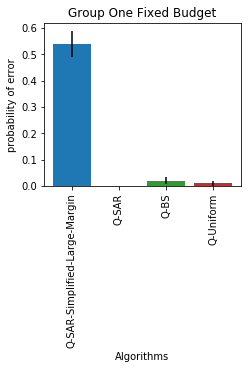

In [7]:
# save results
'''
with open('../saved_results/Group_One_Fixed_Budget.pickle', 'wb') as handle:
     pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../saved_results/Group_One_Fixed_Budget.pickle', 'rb') as handle:
    results = pickle.load(handle)
'''
plot_eva(results, 'pe', paper_flag = True, with_para = True, title = 'Group_One_Fixed_Budget', log_scale = False)